## Легенда

В галактике Андромеда V скоро наступит сезон высоких продаж. Сейчас в галактике сложная маршрутная сеть. Маршрутом там называют цепочку "Start-Steps-End"(вкладка Routes). 

Если Step1-5 пустые, это значит, что товар уже сейчас едет напрямую. 

Если стартовый объект (start) находится далеко от конечной точки (end) или груз требует дополнительной сортировки, то товар будет проходить через промежуточные точки (Step1-5, транзитно-сортировочные центры - ТСЦ*). 

Дирекция опасается, что ТСЦ не справятся с проходящими через них объемами (объемы можно найти на вкладке Volumes). Поэтому было принято решение снизить нагрузку на ТСЦ путем распрямления маршрутной сети, т.е. исключить промежуточные точки (ТСЦ) в тех маршрутах, где соблюдается ряд условий:
1. Если набирается объем на звездолет между двумя объектами, тогда можно исключить ТСЦ, который был между ними. Предполагается, что все звездолеты в галактике 33-паллетные, таргет по утилизации звездолета = 93%, т.е. необходимо, чтобы он был заполнен минимум на 93%. Кроме того, среднее количество штук на паллете отличается в зависимости от места комплектации паллеты. Местом комплектации может быть либо стартовая точка, либо ТСЦ, на которых паллеты разбираются, сортируются и собираются снова. Детали по этим условиям можно найти на вкладке Parameters.
2. Возможны спрямления с дискретностью, т.е., например, прямые машины не каждый день, а по вторникам и четвергам.
3. Спрямление необходимо предлагать с момента, когда стабильно набираются объемы
4. Если образуются промежутки, когда объемы не набираются:
- если эти промежутки меньше 5 дней, то можно предлагать спрямление в маршруте
- предлагается проверить насколько сильно падает утилизация звездолета в эти дни. Если она падает не больше, чем до 70%, то можно предлагать спрямление

**Задание**: Предложить возможные спрямления в формате "маршрут - ТСЦ, который(-ые) убираем из маршрута - объемы, от которых освобождаем ТСЦ, по датам"
1. Описать принципы, доп.предпосылки (если будут) и алгоритм расчета. 
2. Реализовать и предоставить расчет (или скрипт) и результат расчета.

*некоторые объекты на Step1-5 могут иметь суффикс РФЦ - это значит, что на территории этого объекта есть не только ТСЦ, но и сортировочный центр (СЦ), который сортирует товары и отправляет их в последнюю милю. На вкладке Volumes указаны только транзитные объемы, т.е. в нашем случае все объекты на промежуточных точках выступают исключительно в роли ТСЦ.

## План работы

1. **Предобработка**
- импортирую библиотеки и датафреймы
- проведу предобработку данных: изменение формата, транспонирование/расплавление, изменение названия столбцов, введение дополнительных условий
- проведу предобработку данных: проверю на пропуски и дубликаты
2. **Проведу Исследовательский анализ routes**
- Изучу, какие промужеточные центры загружены больше всего
3. **Проведу Исследовательский анализ volumes**
- изучу общее распределение объемов
- сделаю джойны нового датасета с paramaters
- наложу на новый датасет ограничения из routes
- изучу общее число звездолетов в галактике по дням
- выделю Топ-10 самых сильно/слабо загруженных маршрутов по числу звездолетов
- посчитаю долю недозагруженных непрямых маршрутов
- посчитаю число непрямых маршрутов с недельной утилизацией >= таргета, но дневными объемами < таргета
- найду самые загруженные центры из тех, что регулярно отгружают недостаточно заполненные звездолеты
- изучу загрузку Топ-3 загруженных центров по пункту назначения по дате
- предложу список отгрузок центров-кандидатов на выпрямление в формате согласно ТЗ
4. **Сделаю вывод по работе**

## Импорт библиотек и датасетов, предобработка

In [1]:
#импортируем библиотеки

import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

In [2]:
#импортируем датасеты - routes

routes = pd.read_excel('C:\\anaconda3\\Test\\Tests\\test_routes.xlsx', sheet_name='Routes')
routes.info()
display(routes.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7782 entries, 0 to 7781
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Start   7782 non-null   object
 1   End     7782 non-null   object
 2   Step 1  7132 non-null   object
 3   Step 2  4885 non-null   object
 4   Step 3  894 non-null    object
 5   Step 4  68 non-null     object
 6   Step 5  2 non-null      object
dtypes: object(7)
memory usage: 425.7+ KB


,Start,End,Step 1,Step 2,Step 3,Step 4,Step 5
0,Адара_ХАБ,Веритате_ХАБ,Алудра_ТСЦ,Кастор_ТСЦ,Аламак_РФЦ,NaN,NaN
1,Адара_ХАБ,Зубен Хакраби_ХАБ,Алудра_ТСЦ,Чалаван_ТСЦ,Алюла Австралис_РФЦ,NaN,NaN
2,Адара_ХАБ,Огма_ХАБ,Алудра_ТСЦ,Интеркрус_ТСЦ,NaN,NaN,NaN
3,Адара_ХАБ,Садалмелик_ХАБ,Алудра_ТСЦ,Чалаван_ТСЦ,Алюла Австралис_РФЦ,NaN,NaN
4,Адара_ХАБ,Садалсууд_ХАБ,Алудра_ТСЦ,Чалаван_ТСЦ,NaN,NaN,NaN


In [3]:
#дропнем прямые маршруты, переназовем колонки

routes.columns = ['start', 'end', 'step1', 'step2', 'step3', 'step4', 'step5']

routes = routes[['start', 'step1', 'step2', 'step3', 'step4', 'step5', 'end']]

routes = routes[routes['step1'].notna()]

In [4]:
#согласно ТЗ нас интересуют только те центры старта, которые относятся к категориям ТСЦ и РФЦ, отфильтруем согласно ТЗ

routes = routes[routes['start'].str.contains("ТСЦ|РФЦ")].reset_index()

In [5]:
#импортируем датасеты - volumes

volumes = pd.read_excel('C:\\anaconda3\\Test\\Tests\\test_routes.xlsx', sheet_name='Volumes')

volumes.info()
display(volumes.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7210 entries, 0 to 7209
Columns: 124 entries, Start to 2035-12-31 00:00:00
dtypes: int64(122), object(2)
memory usage: 6.8+ MB


,Start,End,2035-09-01 00:00:00,2035-09-02 00:00:00,2035-09-03 00:00:00,2035-09-04 00:00:00,2035-09-05 00:00:00,2035-09-06 00:00:00,2035-09-07 00:00:00,2035-09-08 00:00:00,...,2035-12-22 00:00:00,2035-12-23 00:00:00,2035-12-24 00:00:00,2035-12-25 00:00:00,2035-12-26 00:00:00,2035-12-27 00:00:00,2035-12-28 00:00:00,2035-12-29 00:00:00,2035-12-30 00:00:00,2035-12-31 00:00:00
0,Веритате_ХАБ,Зубен Хакраби_ХАБ,40,44,49,54,60,67,74,83,...,1097,1152,1209,1270,1333,1400,1260,1134,1021,919
1,Веритате_ХАБ,Огма_ХАБ,103,114,127,141,157,174,194,215,...,315,331,347,364,383,402,362,325,293,264
2,Веритате_ХАБ,Садалмелик_ХАБ,41,45,50,56,62,68,76,84,...,590,620,651,683,717,753,678,610,549,494
3,Веритате_ХАБ,Садалсууд_ХАБ,2,2,3,3,3,3,4,4,...,894,938,985,1034,1086,1140,1026,924,831,748
4,Веритате_ХАБ,Садахбия_ХАБ,110,122,136,151,168,186,207,230,...,345,362,380,399,419,440,396,356,321,289


In [6]:
#расплавим таблицу в рабочий формат (длинный)

df = pd.melt(volumes, id_vars=['Start', 'End'], var_name='date', value_name='volume')
df.columns = df.columns.str.lower()

df

#альтернативно можно сделать то же, но менее красиво - через списки словарей и циклы

#column_names = volumes.columns.tolist()

#d = {}
#for i in column_names:
#    d[i] = pd.DataFrame(volumes, columns=['Start', 'End'])
#    for j in range(0, len(volumes.columns)): 
#        d[i]['volume'] = volumes.iloc[:,j]
#        d[i]['date'] = volumes.columns.tolist()[j]
        
#df_combined = pd.concat(d, axis=0).reset_index()
#df_combined 

,start,end,date,volume
0,Веритате_ХАБ,Зубен Хакраби_ХАБ,2035-09-01,40
1,Веритате_ХАБ,Огма_ХАБ,2035-09-01,103
2,Веритате_ХАБ,Садалмелик_ХАБ,2035-09-01,41
3,Веритате_ХАБ,Садалсууд_ХАБ,2035-09-01,2
4,Веритате_ХАБ,Садахбия_ХАБ,2035-09-01,110
...,...,...,...,...
879615,Зубен Эльакриби_ХАБ,Алкалуропс_РФЦ,2035-12-31,34
879616,Зубен Эльакриби_ХАБ,Зубен эль Акраб_ХАБ,2035-12-31,1424
879617,Зубен Эльакриби_ХАБ,Брахиум_ХАБ,2035-12-31,2519
879618,Зубен Эльакриби_ХАБ,Факт_ХАБ,2035-12-31,606


In [7]:
#импортируем датасеты - parameters

parameters = pd.read_excel('C:\\anaconda3\\Test\\Tests\\test_routes.xlsx', sheet_name='Parameters')
parameters.info()
display(parameters.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Place of pallet complectation   94 non-null     object 
 1   Qty, items on pallet            94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


,Place of pallet complectation,"Qty, items on pallet"
0,Веритате_ХАБ,89.646460
1,Зубен Хакраби_ХАБ,134.423592
2,Садалмелик_ХАБ,118.592171
3,Садалсууд_ХАБ,76.184281
4,Садахбия_ХАБ,110.075902


In [8]:
#зададим постоянные Truck utilization target (utilization_target) и Qty of pallets in starship (pallets_per_starship)

utilization_target = 0.93
pallets_per_starship = 33

## Проверка на пропуски

In [9]:
#пропуски в routes, приведение к нижнему регистру

routes_columns = ['start', 'end', 'step1', 'step2', 'step3', 'step4', 'step5']

def routes_count_nan(list):
    
    for file in routes_columns:
        print('- Пропусков в датасете routes/ {}:'.format(file), len(routes[routes[file].isna()]))
        
routes_count_nan(routes_columns)

- Пропусков в датасете routes/ start: 0
- Пропусков в датасете routes/ end: 0
- Пропусков в датасете routes/ step1: 0
- Пропусков в датасете routes/ step2: 739
- Пропусков в датасете routes/ step3: 1223
- Пропусков в датасете routes/ step4: 1333
- Пропусков в датасете routes/ step5: 1338


In [10]:
#пропуски в parameters, приведение к нижнему регистру

parameters.columns = ['start', 'per_pallet']
parameters['per_pallet'] = round(parameters['per_pallet'])

parameters_columns = ['start', 'per_pallet']

def parameters_count_nan(list):
    
    for file in parameters_columns:
        print('- Пропусков в датасете parameters/ {}:'.format(file), len(parameters[parameters[file].isna()]))
        
parameters_count_nan(parameters_columns)

- Пропусков в датасете parameters/ start: 0
- Пропусков в датасете parameters/ per_pallet: 0


## Проверка на дубликаты

In [11]:
#проверим число дубликатов

print('Дубликатов в таблице routes:', routes.duplicated().sum())
print('Дубликатов в таблице df:', df.duplicated().sum())
print('Дубликатов в таблице parameters:', parameters.duplicated().sum())

Дубликатов в таблице routes: 0
Дубликатов в таблице df: 123
Дубликатов в таблице parameters: 0


In [12]:
#дропнем дубликаты в routes, df

df = df.drop_duplicates().reset_index(drop=True)

## Исследовательский анализ routes

In [13]:
#изучим распределение числа маршрутов по месту старта

routes_by_start = (
            routes.groupby('start')
            .agg({'end': 'nunique'})
            .rename(columns={'end': 'routes'})
            .sort_values(by='routes', ascending = False)
            .reset_index()
)

routes_by_start.head(5)

,start,routes
0,Альхена_РФЦ,88
1,Васат_РФЦ,87
2,Алкаид_РФЦ,86
3,Мирах_РФЦ,86
4,Алудра_ТСЦ,84


Text(0, 0.5, 'Число маршрутов, ед')

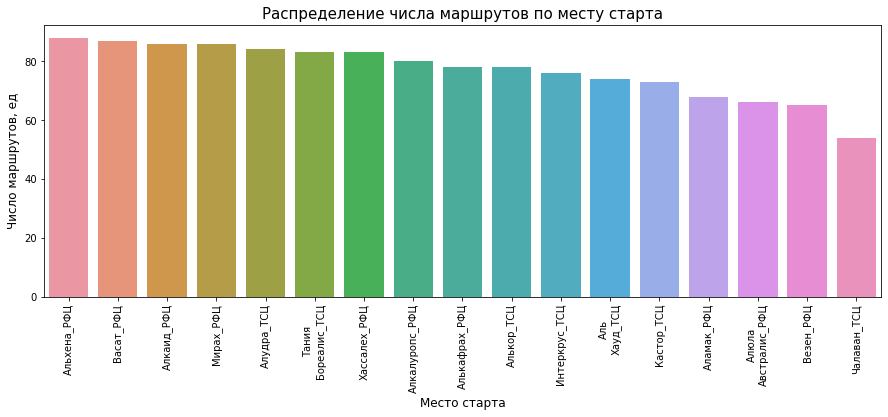

In [14]:
#распределение числа маршрутов по месту старта

plt.figure(figsize = (15,5))
plt.title('Распределение числа маршрутов по месту старта', fontsize = 15)
sns.barplot(data = routes_by_start, x = 'start', y = 'routes')

plt.xlabel('Место старта', fontsize = 12)

old_ticks, old_labels = plt.xticks()
plt.xticks(old_ticks, ['\n'.join(label.get_text().split()) for label in old_labels])
plt.xticks(rotation = 90)
plt.ylabel('Число маршрутов, ед', fontsize = 12)

**Вывод:** распределение по числу маршрутов достаточно равномерно для Топ-10 отгрузочных центров

Text(0, 0.5, 'Число маршрутов, ед')

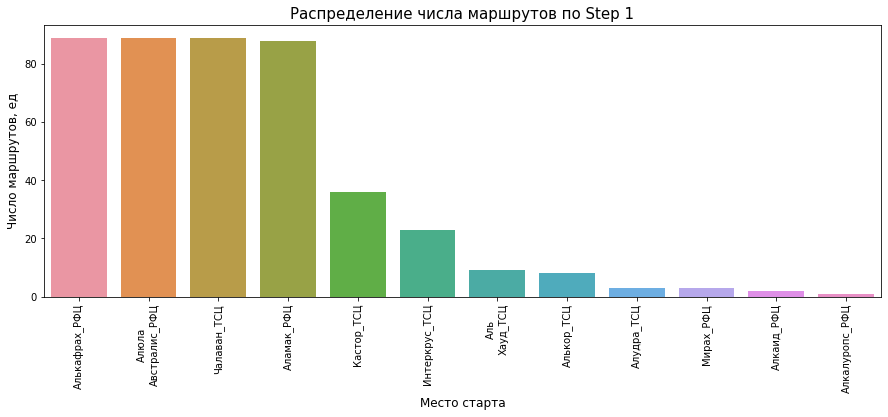

In [15]:
#изучим распределение числа маршрутов по Step 1

routes_by_1_step = (
            routes.groupby('step1')
            .agg({'end': 'nunique'})
            .rename(columns={'end': 'routes'})
            .sort_values(by='routes', ascending = False)
            .reset_index()
)

plt.figure(figsize = (15,5))
plt.title('Распределение числа маршрутов по Step 1', fontsize = 15)
sns.barplot(data = routes_by_1_step, x = 'step1', y = 'routes')

plt.xlabel('Место старта', fontsize = 12)

old_ticks, old_labels = plt.xticks()
plt.xticks(old_ticks, ['\n'.join(label.get_text().split()) for label in old_labels])
plt.xticks(rotation = 90)
plt.ylabel('Число маршрутов, ед', fontsize = 12)

**Вывод:** на перегрузке `step1` есть 4 центра, через которые проходит больше всего маршрутов: Алькафрах_РФЦ (89), Алюла Австралис_РФЦ (89), Чалаван_ТСЦ (89) и Аламак_РФЦ (88). Меньше всего - через Алкалуропс_РФЦ (1).

Text(0, 0.5, 'Число маршрутов, ед')

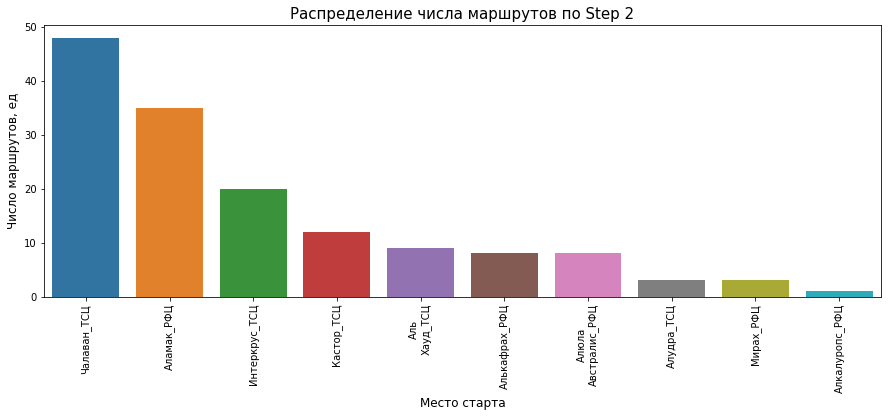

In [16]:
#изучим распределение числа маршрутов по Step 2

routes_by_2_step = (
            routes.groupby('step2')
            .agg({'end': 'nunique'})
            .rename(columns={'end': 'routes'})
            .sort_values(by='routes', ascending = False)
            .reset_index()
)

plt.figure(figsize = (15, 5))
plt.title('Распределение числа маршрутов по Step 2', fontsize = 15)
sns.barplot(data = routes_by_2_step, x = 'step2', y = 'routes')

plt.xlabel('Место старта', fontsize = 12)

old_ticks, old_labels = plt.xticks()
plt.xticks(old_ticks, ['\n'.join(label.get_text().split()) for label in old_labels])
plt.xticks(rotation = 90)
plt.ylabel('Число маршрутов, ед', fontsize = 12)

**Вывод:** на перегрузке `step2` есть 2 центра, через которые проходит больше всего маршрутов: Чалаван_ТСЦ (48) и Аламак_РФЦ (35).

Text(0, 0.5, 'Число маршрутов, ед')

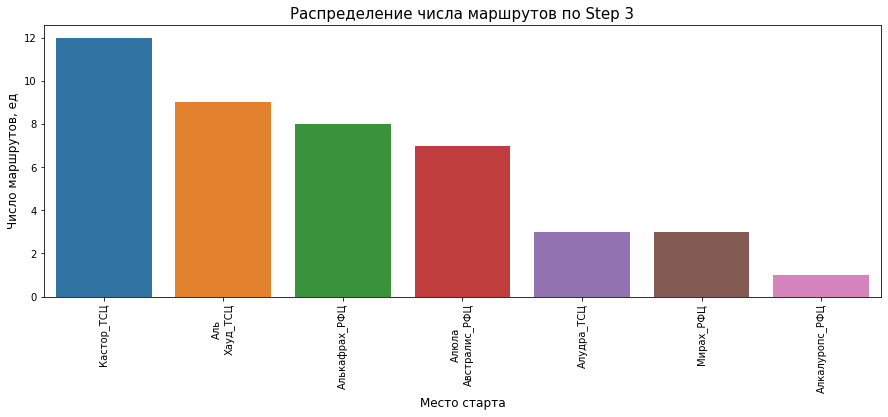

In [17]:
#изучим распределение числа маршрутов по Step 3

routes_by_3_step = (
            routes.groupby('step3')
            .agg({'end': 'nunique'})
            .rename(columns={'end': 'routes'})
            .sort_values(by='routes', ascending = False)
            .reset_index()
)

plt.figure(figsize = (15, 5))
plt.title('Распределение числа маршрутов по Step 3', fontsize = 15)
sns.barplot(data = routes_by_3_step, x = 'step3', y = 'routes')

plt.xlabel('Место старта', fontsize = 12)

old_ticks, old_labels = plt.xticks()
plt.xticks(old_ticks, ['\n'.join(label.get_text().split()) for label in old_labels])
plt.xticks(rotation = 90)
plt.ylabel('Число маршрутов, ед', fontsize = 12)

**Вывод:** на перегрузке `step3` всего 7 промежуточных центров, Кастор_ТСЦ (12), Аль Хауд_ТСЦ (9) и Алькафрах_РФЦ (8) - лидеры.
Меньше всего перегрузок на Алкалуропс_РФЦ - 1. 

Text(0, 0.5, 'Число маршрутов, ед')

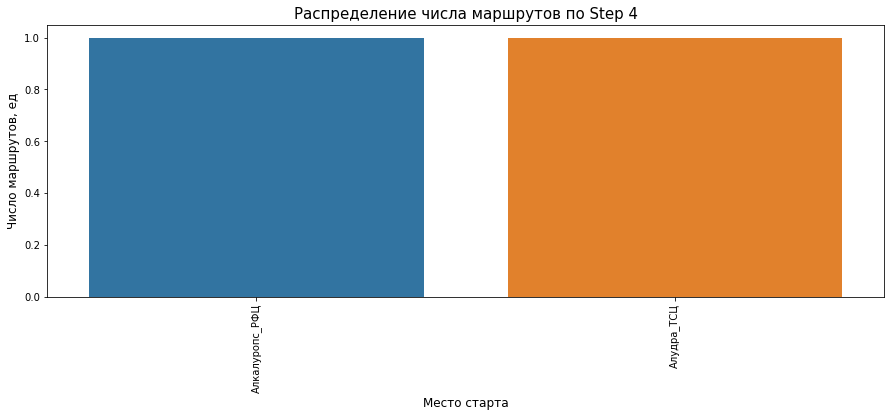

In [18]:
#изучим распределение числа маршрутов по Step 4

routes_by_4_step = (
            routes.groupby('step4')
            .agg({'end': 'nunique'})
            .rename(columns={'end': 'routes'})
            .sort_values(by='routes', ascending = False)
            .reset_index()
)

plt.figure(figsize = (15, 5))
plt.title('Распределение числа маршрутов по Step 4', fontsize = 15)
sns.barplot(data = routes_by_4_step, x = 'step4', y = 'routes')

plt.xlabel('Место старта', fontsize = 12)

old_ticks, old_labels = plt.xticks()
plt.xticks(old_ticks, ['\n'.join(label.get_text().split()) for label in old_labels])
plt.xticks(rotation = 90)
plt.ylabel('Число маршрутов, ед', fontsize = 12)

**Вывод:** на перегрузке `step4` всего 2 промежуточных центра: Алкалуропс_РФЦ (1) и Алудра_ТСЦ (1).

In [19]:
#изучим распределение числа маршрутов по Step 5

routes_by_5_step = (
            routes.groupby('step5')
            .agg({'end': 'nunique'})
            .rename(columns={'end': 'routes'})
            .sort_values(by='routes', ascending = False)
            .reset_index()
)

routes_by_5_step

,step5,routes


**Вывод:** на перегрузке `step5` нет промежуточных центров, удовлетворяющих ТЗ.

## Исследовательский анализ df (ex-volumes)

In [20]:
#изучим объемы

df['volume'].describe()

count    879497.000000
mean       6123.261177
std       17298.124121
min           0.000000
25%         163.000000
50%        1009.000000
75%        4222.000000
max      416847.000000
Name: volume, dtype: float64

In [21]:
#сджойним df + parameters

df = pd.merge(df, parameters, how = 'left', on = 'start')

print('Осталось пропусков в таблице df/ per_pallet:', df['per_pallet'].isna().sum())

Осталось пропусков в таблице df/ per_pallet: 0


In [22]:
#добавим фактическое число паллет, звездолетов и % утилизации звездолетов
#преобразуем дату-время в дату

df['vol_per_pallet'] = df['volume']/df['per_pallet']
df['starships'] = df['vol_per_pallet']/pallets_per_starship

#df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date

display(df.sample())
print('Число отгрузок:', len(df))

,start,end,date,volume,per_pallet,vol_per_pallet,starships
227043,Минкар_КГТ,Корнефорос_ХАБ,2035-10-01,1514,2.0,757.0,22.939394


Число отгрузок: 900996


In [23]:
#добавим в routes склейку для создания списка

routes['start_end'] = routes['start'] + '/' + routes['end']
routes['start_step1'] = routes['start'] + '/' + routes['step1']
routes['step1_step2'] = routes['step1'] + '/' + routes['step2']
routes['step2_step3'] = routes['step2'] + '/' + routes['step3']
routes['step3_step4'] = routes['step3'] + '/' + routes['step4']
routes['step4_step5'] = routes['step4'] + '/' + routes['step5']
routes['step5_end'] = routes['step5'] + '/' + routes['end']

#добавим в routes новые склейки для создания списков

list_routes = list(set(routes['start_end']))
list_routes_start_1 = list(set(routes['start_step1']))
list_routes_s1_s2 = list(set(routes['step1_step2']))
list_routes_s2_s3 = list(set(routes['step2_step3']))
list_routes_s3_s4 = list(set(routes['step3_step4']))
list_routes_s4_s5 = list(set(routes['step4_step5']))
list_routes_s5_end = list(set(routes['step5_end']))

list_routes_all = list_routes + list_routes_start_1 +\
list_routes_s1_s2 + list_routes_s2_s3 + list_routes_s3_s4 + list_routes_s4_s5 + list_routes_s5_end

#добавим в df склейку start/end для создания списка

warnings.filterwarnings('ignore')

df['start_end'] = df['start'] + '/' + df['end']

#list_df = list(set(df['start_end']))

In [24]:
#оставим отгрузки только по тем маршрутам, где есть перегрузка в routes

df = df[df['start_end'].isin(list_routes_all) == True]
    
print('Число маршрутов, где есть перегрузка в routes:', len(df))

Число маршрутов, где есть перегрузка в routes: 152372


In [25]:
#основаня информация по датам

print('Дата/время начала наблюдений:', df['date'].min())
print('Дата/время конца наблюдений:', df['date'].max())
print('Длительность наблюдений, дней:', df['date'].max() - df['date'].min())

Дата/время начала наблюдений: 2035-09-01 00:00:00
Дата/время конца наблюдений: 2035-12-31 00:00:00
Длительность наблюдений, дней: 121 days 00:00:00


<Figure size 1440x1080 with 0 Axes>

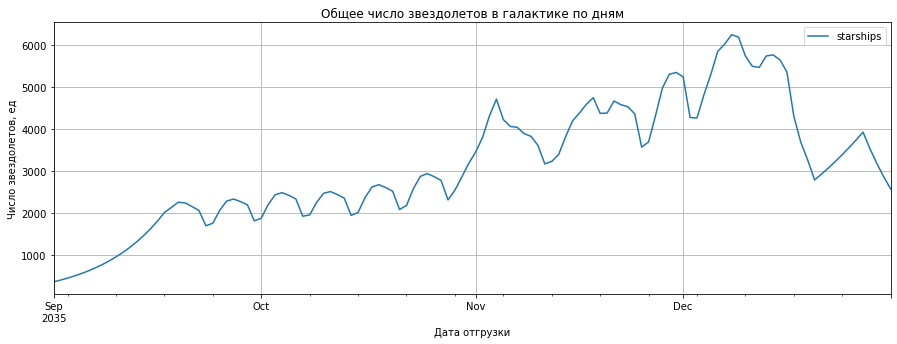

In [26]:
plt.figure(figsize = (20,15))  

df.pivot_table(
        index='date', values='starships', aggfunc='sum'
        ).plot(grid=True, figsize=(15, 5))
        
plt.ylabel('Число звездолетов, ед')
plt.xlabel('Дата отгрузки')
plt.title('Общее число звездолетов в галактике по дням')
plt.show()

**Вывод:** 
- число звездолетов за отчетный период равномерно увеличивается 
- существует ярко выраженная недельная цикличность: на выходные число звездолетов уменьшается
- в начале ноября и в конце декабря наблюдается спад числа звездолетов в галактике, последний, видимо, связан с тем, что в галактике отмечают Новый год

In [27]:
#выделим Топ-10 самых сильно/слабо загруженных маршрутов по числу звездолетов:

starships_by_routes = (
            df.groupby(['start','end'])
            .agg({'starships': 'sum'})
            .sort_values(by='starships', ascending = False)
            .reset_index()
)

display(starships_by_routes.head(10))
display(starships_by_routes.tail(10))

,start,end,starships
0,Алькор_ТСЦ,Пропус_ХАБ,4766.859231
1,Алькор_ТСЦ,Ицар_ХАБ,4422.381904
2,Алькор_ТСЦ,Альхена_РФЦ,4315.533419
3,Алькор_ТСЦ,Азеллус Терция_ХАБ,4077.813669
4,Алькор_ТСЦ,Азеллус Прима_ХАБ,3810.185472
5,Алькор_ТСЦ,Мирзам_ХАБ,3549.947346
6,Интеркрус_ТСЦ,Дубхе_ХАБ,3341.038151
7,Интеркрус_ТСЦ,Сарин_ХАБ,3268.426641
8,Интеркрус_ТСЦ,Пропус_ХАБ,3201.224548
9,Алькор_ТСЦ,Сегинус_ХАБ,3032.584139


,start,end,starships
1225,Алкалуропс_РФЦ,Азеллус Секунда_ХАБ,0.371152
1226,Алкалуропс_РФЦ,Скат_ХАБ,0.371152
1227,Везен_РФЦ,Веритате_ХАБ,0.268655
1228,Везен_РФЦ,Интеркрус_ТСЦ,0.245658
1229,Алкалуропс_РФЦ,Титавин_ХАБ,0.213314
1230,Алкалуропс_РФЦ,Махасим_ХАБ,0.196731
1231,Алкалуропс_РФЦ,Алькафрах_РФЦ,0.195061
1232,Алкалуропс_РФЦ,Нембус_ХАБ,0.189692
1233,Алкалуропс_РФЦ,Факт_ХАБ,0.189454
1234,Алкалуропс_РФЦ,Адхил_ХАБ,0.189454


In [28]:
#оставим только те маршруты, на которых не каждый день набирается необходимый процент по утилизации

df_cut = df[df['starships'] <= utilization_target]

print('Число непрямых отгрузок', len(df_cut))
display(df_cut.head())

Число непрямых отгрузок 94635


,start,end,date,volume,per_pallet,vol_per_pallet,starships,start_end
963,Мирах_РФЦ,Веритате_ХАБ,2035-09-01,4,334.0,0.011976,0.000363,Мирах_РФЦ/Веритате_ХАБ
964,Мирах_РФЦ,Зубен Хакраби_ХАБ,2035-09-01,490,334.0,1.467066,0.044457,Мирах_РФЦ/Зубен Хакраби_ХАБ
965,Мирах_РФЦ,Огма_ХАБ,2035-09-01,467,334.0,1.398204,0.042370,Мирах_РФЦ/Огма_ХАБ
966,Мирах_РФЦ,Садалмелик_ХАБ,2035-09-01,313,334.0,0.937126,0.028398,Мирах_РФЦ/Садалмелик_ХАБ
967,Мирах_РФЦ,Садалсууд_ХАБ,2035-09-01,163,334.0,0.488024,0.014789,Мирах_РФЦ/Садалсууд_ХАБ


In [29]:
#выделим топ и долю наименее загруженных непрямых маршрутов по числу звездолетов:

super_low_vol = (
            df_cut.groupby(['start','end'])
            .agg({'starships': 'sum'})
            .sort_values(by='starships', ascending = False)
            .reset_index()
)

print('Общее число непрямых маршрутов:', len(starships_by_routes))
print('Число маршрутов недозагруженных непрямых маршрутов:', len(super_low_vol))
print('Доля недозагруженных непрямых маршрутов:', round(len(super_low_vol)/len(starships_by_routes),2))

Общее число непрямых маршрутов: 1235
Число маршрутов недозагруженных непрямых маршрутов: 1118
Доля недозагруженных непрямых маршрутов: 0.91


In [30]:
#сгруппируем данные по неделям

group_by_week = df_cut.groupby(
    ['start', 'end', df_cut['date']
     .dt.strftime('%W')])['starships'].sum().reset_index()

#group_by_week = group_by_week.rename(columns={'date': 'week'})

group_by_week.sample()

,start,end,date,starships
5406,Алькафрах_РФЦ,Альфард_ХАБ,40,2.681245


In [31]:
#оставим только те маршруты, на которых набирается хотя бы 1 звездолет в неделю
#это кандидаты на то, что бы снизить частоту отправок/ выпрямление

group_by_week_w = group_by_week[group_by_week['starships'] >= utilization_target]

print('Непрямых маршрутов с недельной утилизацией >= таргета, но дневными объемами < таргета:', 
      len(group_by_week_w))
group_by_week_w.describe()

Непрямых маршрутов с недельной утилизацией >= таргета, но дневными объемами < таргета: 8828


,starships
count,8828.000000
mean,2.501968
std,1.105450
min,0.930230
25%,1.581232
50%,2.323965
75%,3.309028
max,10.072881


**Вывод:** к сожалению, утилизация звездолетов в галактике неоптимальна, например, половина (медиана) звездолетов имеют загрузку всего на 2,3 полета в неделю. Звездному Альянсу рекомендовано оптимизировать цепи поставок

,start,starships
0,Алкаид_РФЦ,2953.158358
1,Мирах_РФЦ,2842.205589
2,Алькафрах_РФЦ,2824.840131
3,Алудра_ТСЦ,2785.153221
4,Васат_РФЦ,2464.758727
5,Альхена_РФЦ,2077.001794
6,Кастор_ТСЦ,2047.536190
7,Хассалех_РФЦ,1950.592899
8,Алюла Австралис_РФЦ,1672.988636
9,Везен_РФЦ,1183.884417


Text(0, 0.5, 'Число звездолетов, ед')

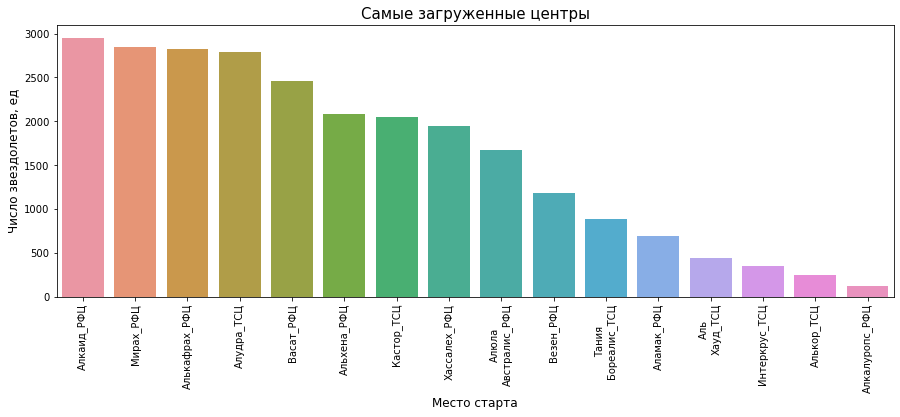

In [32]:
#найдем самые загруженные центры из тех, что регулярно отгружают недостаточно заполненные звездолеты

overloaded = (
            df_cut.groupby('start')
            .agg({'starships': 'sum'})
            .sort_values(by='starships', ascending = False)
            .reset_index()
)

display(overloaded.head(20))

plt.figure(figsize = (15, 5))
plt.title('Самые загруженные центры', fontsize = 15)
sns.barplot(data = overloaded.head(20), x = 'start', y = 'starships')

plt.xlabel('Место старта', fontsize = 12)

old_ticks, old_labels = plt.xticks()
plt.xticks(old_ticks, ['\n'.join(label.get_text().split()) for label in old_labels])
plt.xticks(rotation = 90)
plt.ylabel('Число звездолетов, ед', fontsize = 12)

Есть явный кандидат на выпрямление: **Алкаид_РФЦ**

In [33]:
#изучим отгрузки из Алкаид_РФЦ

alkaid = df_cut[df_cut['start'] == 'Алкаид_РФЦ']
alkaid['starships'].describe()

count    8617.000000
mean        0.342713
std         0.245265
min         0.000855
25%         0.143939
50%         0.293988
75%         0.503666
max         0.929985
Name: starships, dtype: float64

In [34]:
alkaid_routes = (
            alkaid.groupby(['start','end'])
            .agg({'starships': 'sum'})
            .sort_values(by='starships', ascending = False)
            .reset_index()
)
alkaid_routes

,start,end,starships
0,Алкаид_РФЦ,Пропус_ХАБ,86.683407
1,Алкаид_РФЦ,Исида_ХАБ,51.780547
2,Алкаид_РФЦ,Маркеб_ХАБ,51.272361
3,Алкаид_РФЦ,Нембус_ХАБ,50.492058
4,Алкаид_РФЦ,Мицар_ХАБ,50.427786
...,...,...,...
80,Алкаид_РФЦ,Алкалуропс_РФЦ,10.853128
81,Алкаид_РФЦ,Тания Бореалис_ТСЦ,3.838587
82,Алкаид_РФЦ,Принцепс_ХАБ,2.452468
83,Алкаид_РФЦ,Интеркрус_ТСЦ,2.345430


<Figure size 1440x1080 with 0 Axes>

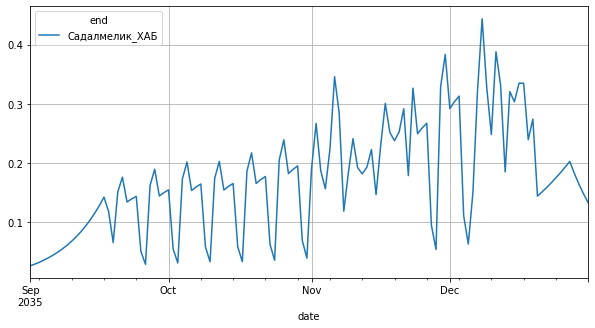

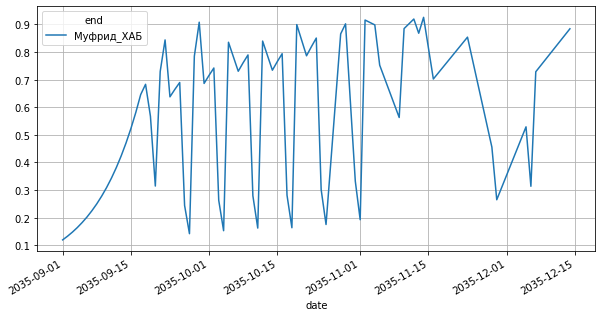

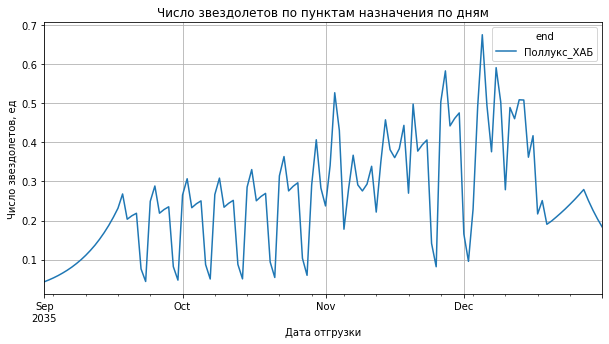

In [36]:
alkaid_end_list = set(list(alkaid['end']))

plt.figure(figsize = (20,15))  

for i in random.sample(alkaid_end_list,3):
    alkaid[alkaid['end'] == i].pivot_table(
        index='date', columns='end', values='starships', aggfunc='sum'
        ).plot(grid=True, figsize=(10, 5))
        
plt.ylabel('Число звездолетов, ед')
plt.xlabel('Дата отгрузки')
plt.title('Число звездолетов по пунктам назначения по дням')
plt.show()

**Вывод:** `Алкаид_РФЦ` повторяет стандартный паттерн поведения по галактике по всем 85 направлениям отгрузки: постепенный рост, ярко выраженная недельная цикличность и спад под конец года

Изучим отгрузки из **Мирах_РФЦ**

In [37]:
mirah = df_cut[df_cut['start'] == 'Мирах_РФЦ']
mirah['starships'].describe()

count    8070.000000
mean        0.352194
std         0.248557
min         0.000363
25%         0.147931
50%         0.316413
75%         0.521162
max         0.929958
Name: starships, dtype: float64

In [38]:
mirah_routes = (
            mirah.groupby(['start','end'])
            .agg({'starships': 'sum'})
            .sort_values(by='starships', ascending = False)
            .reset_index()
)
mirah_routes

,start,end,starships
0,Мирах_РФЦ,Пропус_ХАБ,69.090274
1,Мирах_РФЦ,Садахбия_ХАБ,51.989839
2,Мирах_РФЦ,Мускида_ХАБ,51.183542
3,Мирах_РФЦ,Масим_ХАБ,49.533116
4,Мирах_РФЦ,Зубен Эльакриби_ХАБ,49.037017
...,...,...,...
79,Мирах_РФЦ,Интеркрус_ТСЦ,3.171022
80,Мирах_РФЦ,Алкалуропс_РФЦ,2.782163
81,Мирах_РФЦ,Тания Бореалис_ТСЦ,2.272092
82,Мирах_РФЦ,Принцепс_ХАБ,1.589095


<Figure size 1440x1080 with 0 Axes>

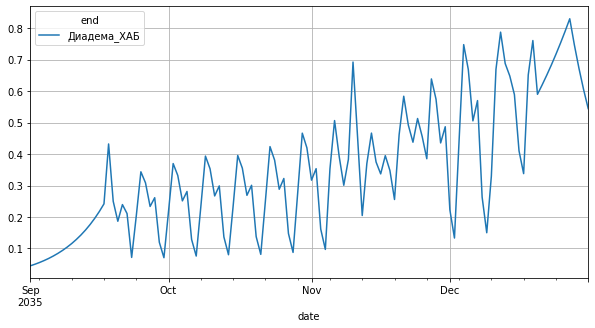

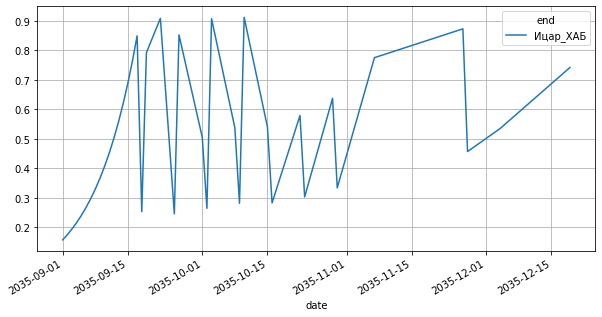

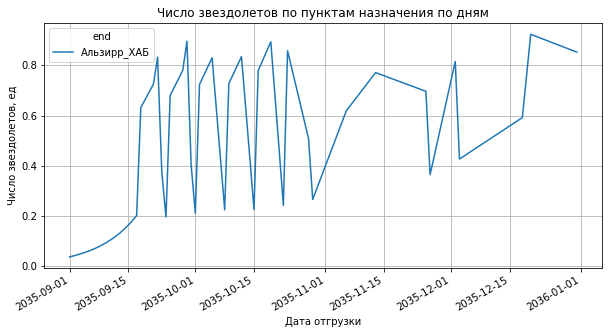

In [39]:
mirah_end_list = set(list(mirah['end']))

plt.figure(figsize = (20,15))  

for i in random.sample(mirah_end_list,3):
    mirah[mirah['end'] == i].pivot_table(
        index='date', columns='end', values='starships', aggfunc='sum'
        ).plot(grid=True, figsize=(10, 5))
        
plt.ylabel('Число звездолетов, ед')
plt.xlabel('Дата отгрузки')
plt.title('Число звездолетов по пунктам назначения по дням')
plt.show()

**Вывод:** `Мирах_РФЦ` повторяет стандартный паттерн поведения по галактике по всем 84 направлениям отгрузки: постепенный рост, ярко выраженная недельная цикличность и спад под конец года

### Изучим отгрузки из **Алькафрах_РФЦ**

In [40]:
alkafrah = df_cut[df_cut['start'] == 'Алькафрах_РФЦ']
alkafrah['starships'].describe()

count    8072.000000
mean        0.349955
std         0.244403
min         0.000491
25%         0.150164
50%         0.301392
75%         0.521540
max         0.929894
Name: starships, dtype: float64

In [41]:
alkafrah_routes = (
            alkafrah.groupby(['start','end'])
            .agg({'starships': 'sum'})
            .sort_values(by='starships', ascending = False)
            .reset_index()
)
alkafrah_routes

,start,end,starships
0,Алькафрах_РФЦ,Пропус_ХАБ,93.955938
1,Алькафрах_РФЦ,Диадема_ХАБ,51.682555
2,Алькафрах_РФЦ,Неккар_ХАБ,50.843407
3,Алькафрах_РФЦ,Алкалуропс_РФЦ,50.108272
4,Алькафрах_РФЦ,Мускида_ХАБ,48.151351
...,...,...,...
74,Алькафрах_РФЦ,Факт_ХАБ,16.032105
75,Алькафрах_РФЦ,Азеллус Прима_ХАБ,12.615070
76,Алькафрах_РФЦ,Интеркрус_ТСЦ,4.441278
77,Алькафрах_РФЦ,Тания Бореалис_ТСЦ,1.708763


<Figure size 1440x1080 with 0 Axes>

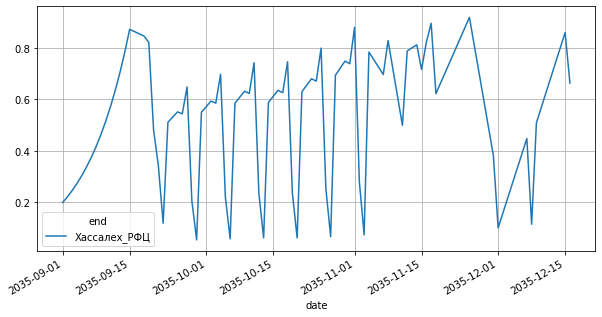

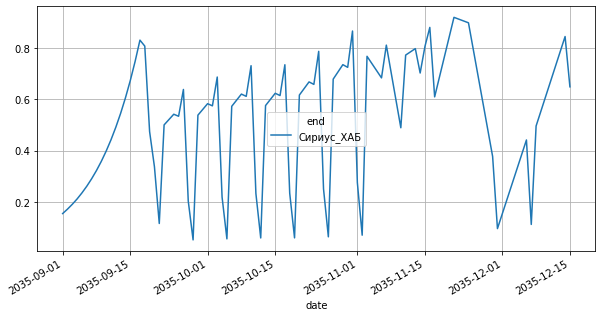

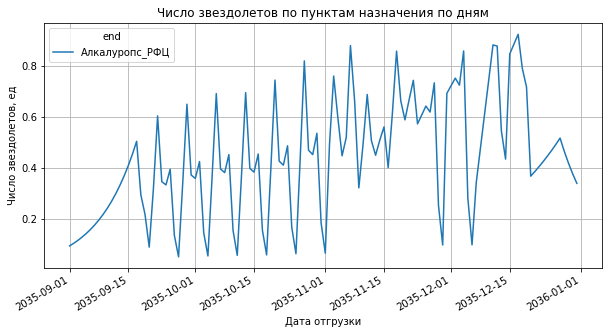

In [42]:
alkafrah_end_list = set(list(alkafrah['end']))

plt.figure(figsize = (20,15))  

for i in random.sample(alkafrah_end_list,3):
    alkafrah[alkafrah['end'] == i].pivot_table(
        index='date', columns='end', values='starships', aggfunc='sum'
        ).plot(grid=True, figsize=(10, 5))
        
plt.ylabel('Число звездолетов, ед')
plt.xlabel('Дата отгрузки')
plt.title('Число звездолетов по пунктам назначения по дням')
plt.show()

**Вывод:** `Алькафрах_РФЦ` повторяет стандартный паттерн поведения по галактике по всем 79 направлениям отгрузки: постепенный рост, ярко выраженная недельная цикличность и спад под конец года

In [43]:
top10_list = list(overloaded['start'].head(10))
top10_list

['Алкаид_РФЦ',
 'Мирах_РФЦ',
 'Алькафрах_РФЦ',
 'Алудра_ТСЦ',
 'Васат_РФЦ',
 'Альхена_РФЦ',
 'Кастор_ТСЦ',
 'Хассалех_РФЦ',
 'Алюла Австралис_РФЦ',
 'Везен_РФЦ']

In [44]:
for i in top10_list:
    display(df_cut[df_cut['start'] == i].loc[:,['start', 'end', 'date', 'volume']].reset_index())

,index,start,end,date,volume
0,3720,Алкаид_РФЦ,Веритате_ХАБ,2035-09-01,7
1,3721,Алкаид_РФЦ,Зубен Хакраби_ХАБ,2035-09-01,278
2,3722,Алкаид_РФЦ,Огма_ХАБ,2035-09-01,309
3,3723,Алкаид_РФЦ,Садалмелик_ХАБ,2035-09-01,217
4,3724,Алкаид_РФЦ,Садалсууд_ХАБ,2035-09-01,501
...,...,...,...,...,...
8612,897413,Алкаид_РФЦ,Зубен Эльшемали_ХАБ,2035-12-31,5596
8613,897414,Алкаид_РФЦ,Алкалуропс_РФЦ,2035-12-31,614
8614,897416,Алкаид_РФЦ,Брахиум_ХАБ,2035-12-31,5064
8615,897417,Алкаид_РФЦ,Факт_ХАБ,2035-12-31,1113


,index,start,end,date,volume
0,963,Мирах_РФЦ,Веритате_ХАБ,2035-09-01,4
1,964,Мирах_РФЦ,Зубен Хакраби_ХАБ,2035-09-01,490
2,965,Мирах_РФЦ,Огма_ХАБ,2035-09-01,467
3,966,Мирах_РФЦ,Садалмелик_ХАБ,2035-09-01,313
4,967,Мирах_РФЦ,Садалсууд_ХАБ,2035-09-01,163
...,...,...,...,...,...
8065,894658,Мирах_РФЦ,Алкалуропс_РФЦ,2035-12-31,225
8066,894659,Мирах_РФЦ,Зубен эль Акраб_ХАБ,2035-12-31,3733
8067,894660,Мирах_РФЦ,Брахиум_ХАБ,2035-12-31,7897
8068,894661,Мирах_РФЦ,Факт_ХАБ,2035-12-31,1479


,index,start,end,date,volume
0,4143,Алькафрах_РФЦ,Веритате_ХАБ,2035-09-01,5
1,4144,Алькафрах_РФЦ,Зубен Хакраби_ХАБ,2035-09-01,407
2,4145,Алькафрах_РФЦ,Огма_ХАБ,2035-09-01,404
3,4146,Алькафрах_РФЦ,Садалмелик_ХАБ,2035-09-01,215
4,4147,Алькафрах_РФЦ,Садалсууд_ХАБ,2035-09-01,386
...,...,...,...,...,...
8067,897836,Алькафрах_РФЦ,Зубен Эльшемали_ХАБ,2035-12-31,3604
8068,897837,Алькафрах_РФЦ,Алкалуропс_РФЦ,2035-12-31,2067
8069,897838,Алькафрах_РФЦ,Зубен эль Акраб_ХАБ,2035-12-31,3604
8070,897840,Алькафрах_РФЦ,Факт_ХАБ,2035-12-31,1174


,index,start,end,date,volume
0,6604,Алудра_ТСЦ,Веритате_ХАБ,2035-09-01,21
1,6605,Алудра_ТСЦ,Зубен Хакраби_ХАБ,2035-09-01,337
2,6606,Алудра_ТСЦ,Огма_ХАБ,2035-09-01,628
3,6607,Алудра_ТСЦ,Садалмелик_ХАБ,2035-09-01,266
4,6608,Алудра_ТСЦ,Садалсууд_ХАБ,2035-09-01,83
...,...,...,...,...,...
7809,900296,Алудра_ТСЦ,Зубен эль Генуби_ХАБ,2035-12-31,1979
7810,900298,Алудра_ТСЦ,Алкалуропс_РФЦ,2035-12-31,359
7811,900299,Алудра_ТСЦ,Зубен эль Акраб_ХАБ,2035-12-31,2583
7812,900301,Алудра_ТСЦ,Факт_ХАБ,2035-12-31,1327


,index,start,end,date,volume
0,1940,Васат_РФЦ,Веритате_ХАБ,2035-09-01,4
1,1941,Васат_РФЦ,Зубен Хакраби_ХАБ,2035-09-01,56
2,1942,Васат_РФЦ,Огма_ХАБ,2035-09-01,48
3,1943,Васат_РФЦ,Садалмелик_ХАБ,2035-09-01,32
4,1944,Васат_РФЦ,Садалсууд_ХАБ,2035-09-01,264
...,...,...,...,...,...
9839,895635,Васат_РФЦ,Алкалуропс_РФЦ,2035-12-31,1848
9840,895636,Васат_РФЦ,Зубен эль Акраб_ХАБ,2035-12-31,1947
9841,895637,Васат_РФЦ,Брахиум_ХАБ,2035-12-31,309
9842,895638,Васат_РФЦ,Факт_ХАБ,2035-12-31,469


,index,start,end,date,volume
0,1851,Альхена_РФЦ,Веритате_ХАБ,2035-09-01,21
1,1852,Альхена_РФЦ,Зубен Хакраби_ХАБ,2035-09-01,508
2,1853,Альхена_РФЦ,Огма_ХАБ,2035-09-01,918
3,1854,Альхена_РФЦ,Садалмелик_ХАБ,2035-09-01,206
4,1855,Альхена_РФЦ,Садалсууд_ХАБ,2035-09-01,1091
...,...,...,...,...,...
4322,895543,Альхена_РФЦ,Исида_ХАБ,2035-12-31,3745
4323,895547,Альхена_РФЦ,Алкалуропс_РФЦ,2035-12-31,599
4324,895548,Альхена_РФЦ,Зубен эль Акраб_ХАБ,2035-12-31,4376
4325,895550,Альхена_РФЦ,Факт_ХАБ,2035-12-31,2839


,index,start,end,date,volume
0,1502,Кастор_ТСЦ,Веритате_ХАБ,2035-09-01,32
1,1503,Кастор_ТСЦ,Зубен Хакраби_ХАБ,2035-09-01,487
2,1504,Кастор_ТСЦ,Огма_ХАБ,2035-09-01,629
3,1505,Кастор_ТСЦ,Садалмелик_ХАБ,2035-09-01,371
4,1506,Кастор_ТСЦ,Садалсууд_ХАБ,2035-09-01,373
...,...,...,...,...,...
4328,895193,Кастор_ТСЦ,Фуруд_ХАБ,2035-12-31,4769
4329,895194,Кастор_ТСЦ,Исида_ХАБ,2035-12-31,3608
4330,895198,Кастор_ТСЦ,Алкалуропс_РФЦ,2035-12-31,619
4331,895201,Кастор_ТСЦ,Факт_ХАБ,2035-12-31,1643


,index,start,end,date,volume
0,4055,Хассалех_РФЦ,Зубен Хакраби_ХАБ,2035-09-01,37
1,4056,Хассалех_РФЦ,Огма_ХАБ,2035-09-01,43
2,4057,Хассалех_РФЦ,Садалмелик_ХАБ,2035-09-01,16
3,4058,Хассалех_РФЦ,Садалсууд_ХАБ,2035-09-01,71
4,4059,Хассалех_РФЦ,Садахбия_ХАБ,2035-09-01,38
...,...,...,...,...,...
10043,897747,Хассалех_РФЦ,Зубен Эльшемали_ХАБ,2035-12-31,1067
10044,897749,Хассалех_РФЦ,Зубен эль Акраб_ХАБ,2035-12-31,428
10045,897750,Хассалех_РФЦ,Брахиум_ХАБ,2035-12-31,1210
10046,897751,Хассалех_РФЦ,Факт_ХАБ,2035-12-31,226


,index,start,end,date,volume
0,4932,Алюла Австралис_РФЦ,Веритате_ХАБ,2035-09-01,11
1,4934,Алюла Австралис_РФЦ,Огма_ХАБ,2035-09-01,1109
2,4936,Алюла Австралис_РФЦ,Садалсууд_ХАБ,2035-09-01,945
3,4937,Алюла Австралис_РФЦ,Садахбия_ХАБ,2035-09-01,1359
4,4939,Алюла Австралис_РФЦ,Альбали_ХАБ,2035-09-01,894
...,...,...,...,...,...
3567,898620,Алюла Австралис_РФЦ,Адара_ХАБ,2035-12-31,5162
3568,898624,Алюла Австралис_РФЦ,Зубен эль Генуби_ХАБ,2035-12-31,5066
3569,898626,Алюла Австралис_РФЦ,Алкалуропс_РФЦ,2035-12-31,2013
3570,898627,Алюла Австралис_РФЦ,Зубен эль Акраб_ХАБ,2035-12-31,6537


,index,start,end,date,volume
0,6340,Везен_РФЦ,Веритате_ХАБ,2035-09-01,3
1,6341,Везен_РФЦ,Зубен Хакраби_ХАБ,2035-09-01,91
2,6342,Везен_РФЦ,Огма_ХАБ,2035-09-01,61
3,6343,Везен_РФЦ,Садалмелик_ХАБ,2035-09-01,73
4,6344,Везен_РФЦ,Садалсууд_ХАБ,2035-09-01,166
...,...,...,...,...,...
8035,900032,Везен_РФЦ,Зубен Эльшемали_ХАБ,2035-12-31,1513
8036,900033,Везен_РФЦ,Алкалуропс_РФЦ,2035-12-31,986
8037,900034,Везен_РФЦ,Зубен эль Акраб_ХАБ,2035-12-31,752
8038,900035,Везен_РФЦ,Брахиум_ХАБ,2035-12-31,1717


**Вывод:** предложено снизить нагрузку на Топ-10 самые загруженные РФЦ/ТСЦ (72737 отгрузок)

## Вывод

**Качество данных:**
- данные предоставлены в достаточно числом виде с малым числом дубликатов
- потребовалось расплавить один из датафреймов, так как его формат не удобный для проведения анализа

**Допущения:**
- согласно ТЗ нас интересуют только те центры старта, которые относятся к категориям ТСЦ и РФЦ
- основная задача - снизить нагрузку на ТСЦ и РФЦ
- в расчете не учитывается максимальная допустимая пропускная способность ТСЦ и РФЦ - нет в условии
- в расчете не учитывается то, что перегрузка в некоторых центрах может быть необходимой ввиду особенностей локации - нет в условии
- volume из volumes принято за число упаковок (а их число на паллете взяты из parameters), так как иное не обговорено в условии

**Исследовательский анализ перегрузокчных центров:**
- распределение по числу маршрутов достаточно равномерно для Топ-10 отгрузочных центров
- на перегрузке `step1` есть 4 центра, через которые проходит больше всего маршрутов: Алькафрах_РФЦ (89), Алюла Австралис_РФЦ (89), Чалаван_ТСЦ (89) и Аламак_РФЦ (88). Меньше всего - через Алкалуропс_РФЦ (1)
- на перегрузке `step2` есть 2 центра, через которые проходит больше всего маршрутов: Чалаван_ТСЦ (48) и Аламак_РФЦ (35)
- на перегрузке `step3` всего 7 промежуточных центров, Кастор_ТСЦ (12), Аль Хауд_ТСЦ (9) и Алькафрах_РФЦ (8) - лидеры.
Меньше всего перегрузок на Алкалуропс_РФЦ - 1
- на перегрузке `step4` всего 2 промежуточных центра: Алкалуропс_РФЦ (1) и Алудра_ТСЦ (1)
- на перегрузке `step5` нет промежуточных центров, удовлетворяющих ТЗ

**Исследовательский анализ объемов:**
1. `Обзор`
- общее число отгрузок из ТСЦ и РФЦ: 900996
- число маршрутов, где есть перегрузка в routes: 152372
2. `Даты/время`
- дата/время начала наблюдений: 2035-09-01 
- дата/время конца наблюдений: 2035-12-31 
- длительность наблюдений, дней: 121 days 
- число звездолетов за отчетный период равномерно увеличивается 
- существует ярко выраженная недельная цикличность: на выходные число звездолетов уменьшается
- в начале ноября и в конце декабря наблюдается спад числа звездолетов в галактике, последний, видимо, связан с тем, что в галактике отмечают Новый год
3. `Маршруты`
- общее число непрямых маршрутов: 1235
- число маршрутов недозагруженных непрямых маршрутов: 1118
- доля недозагруженных непрямых маршрутов: 0.91
4. `Утилизация в Галактике`
- непрямых маршрутов с недельной утилизацией >= таргета, но дневными объемами < таргета: 8828
- к сожалению, утилизация звездолетов в галактике неоптимальна, например, половина (медиана) звездолетов имеют загрузку всего на 2,3 полета в неделю. Звездному Альянсу рекомендовано оптимизировать цепи поставок
5. `Кандидаты на спрямление/ уменьшение частотки отгрузок`
- выявлены Топ-10 самых загруженных из центров, в в которых утилизация звездолетов ниже таргета: Алкаид_РФЦ (2953 звездолетов за весь период наблюдений), Мирах_РФЦ (2842), Алькафрах_РФЦ (2824), Алудра_ТСЦ (2785), Васат_РФЦ (2464), Альхена_РФЦ (2077), Кастор_ТСЦ (2047), Хассалех_РФЦ (1950), Алюла Австралис_РФЦ (1672), Везен_РФЦ (1183), Тания Бореалис_ТСЦ (881), Аламак_РФЦ (695), Аль Хауд_ТСЦ (440), Интеркрус_ТСЦ (347), Алькор_ТСЦ (240), Алкалуропс_РФЦ (121)
- проведен анализ Топ-3 центров по месту доставки по датам: все повторяют стандартный паттерн поведения по галактике: постепенный рост, ярко выраженная недельная цикличность и спад под конец года
- предложено снизить нагрузку на Топ-10 самые загруженные РФЦ/ТСЦ (72737 отгрузок за весь период наблюдений)